In [1]:
import csv
import pandas as pd
import networkx as nx
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.vq import kmeans2, whiten
from sklearn.cluster import KMeans
import geopy
import zipcodes
from time import sleep
from geopy.extra.rate_limiter import RateLimiter
from mpl_toolkits.basemap import Basemap

## ALL HELPER FUNCTIONS HERE

dang if I were smart I'd create a python library for this. 

In [2]:
# return indices of valid points-- SHOULD USE THIS INSTEAD WHEN CONSIDERING TWO RELATED SETS OF POINTS!!!
def getOutliers(x, y, outlierConstant):
    a = np.array(x)
    b = np.array(y)
    upper_quartile_a = np.percentile(a, 75)
    lower_quartile_a = np.percentile(a, 25)
    upper_quartile_b = np.percentile(b, 75)
    lower_quartile_b = np.percentile(b, 25)
    IQR_a = (upper_quartile_a - lower_quartile_a) * outlierConstant
    IQR_b = (upper_quartile_b - lower_quartile_b) * outlierConstant
    quartileSet_a = (lower_quartile_a - IQR_a, upper_quartile_a + IQR_a)
    quartileSet_b = (lower_quartile_b - IQR_b, upper_quartile_b + IQR_b)
    valid = []
    for i,v in enumerate(a.tolist()):
        if (v >= quartileSet_a[0] and v <= quartileSet_a[1] and b[i] >= quartileSet_b[0] and b[i] <= quartileSet_b[1]):
            valid.append(i)
    return valid

def createDiGraphK_clean(data, sample_size, k=40, iters=20, name='ktemp'):
    # cluster data using k-means
    valid_idx = np.array(getOutliers(data['Lat'], data['Lon'], 1))
    lat = np.array(data['Lat'])[valid_idx]
    lon = np.array(data['Lon'])[valid_idx]
    coordinates= np.array(list(zip(lat, lon)))
    centroids, labels = kmeans2(whiten(coordinates), k, iter = iters) 
    num_points = len(lat)
    # create graph with k nodes
    G = nx.DiGraph(); 
    for pick_up in range(0,min(sample_size, num_points)):
        
        # get k-means centroid from src and randomize dest based on uniform distribution among all clusters
        rand_idx = random.randint(0, num_points - 1)
        la = lat[rand_idx]
        lo = lon[rand_idx]
        src = labels[rand_idx]
        dest = random.randint(0, k - 1)
        if (dest == src and src != 0):
            dest = 0

        # increase edge weight from src -->  dest by 1 
        if not G.has_node(src):
            G.add_node(src, lat=0, lon=0)
        if not G.has_node(dest):
            G.add_node(dest, lat=0, lon=0)
        if not G.has_edge(src, dest):
            G.add_edge(src, dest, weight=0)
        G[src][dest]['weight'] += 1
        
        G.node[src]['lat'] = (G.node[src]['lat'] +  la) / 2 #keep a running average
        G.node[src]['lon'] =  (G.node[src]['lon'] +  lo) / 2
        
        #print("Adding edge from " + str(src) + " to " + str(dest))
        if (pick_up > 1000 and pick_up % 1000 == 0):
            nx.write_graphml(G, "graphs/" + name + ".graphml")
    return G 

In [3]:
def get_coords(G, pad=0.01):
    # scale graph 
    node_lt = nx.get_node_attributes(G, 'lat').values()
    node_ln = nx.get_node_attributes(G, 'lon').values()
    node_lt = list(filter(lambda x: x != 0, node_lt)) # FILTER OUT ZEROS BC OF A BUG Idk
    node_ln = list(filter(lambda x: x != 0, node_ln))
    c2 = [min(node_lt)-pad, max(node_lt)+pad, min(node_ln)-pad, max(node_ln)+pad]
    print(c2)
    return c2

def get_pos(G, m):
    pos = {}
    #lat = {k:mean(v) for (k,v) in nx.get_node_attributes(test1, 'lat').items()}
    #lon = {k:mean(v) for (k,v) in nx.get_node_attributes(test1, 'lon').items()}
    lt = nx.get_node_attributes(G, 'lat')
    ln = nx.get_node_attributes(G, 'lon')
    for node_num in list(G.nodes()):
        pos[node_num] = m(ln[node_num], lt[node_num]) # KEEP IN MIND THIS IS NOW X,Y
    return pos

# get  some colors
def draw_graph_clean_colors(G, coords=None, shapefiles={}, node_size=600): 
    plt.figure(figsize=(18,12))
    if coords is None:
        coords = get_coords(G)
    m = Basemap(projection='merc',llcrnrlat=coords[0],urcrnrlat=coords[1],llcrnrlon=coords[2], urcrnrlon=coords[3], resolution='h')
    m.drawcoastlines()
    m.drawstates()
    m.fillcontinents(color='blanchedalmond',lake_color='aqua')
    #m = Basemap(projection='merc', width=10, height=10, lat_0=40.783058, lon_0=-73.971252)
    pos = get_pos(G, m)
    
    # create networkx graph 
    print("FINISHED PROJ. COORDINATES...STARTING NODES")
    cmap = plt.cm.Blues
    nx.draw_networkx_nodes(G = G, pos = pos, node_color = get_weighted_nodes(G, 1.0), alpha=0.8,
                           node_size=get_weighted_nodes(G, node_size), cmap=cmap)
    #nx.draw_networkx_edges(G = G, pos = pos, edge_color='white', alpha=0.8, arrows = True)
    for file, name in shapefiles.items():
        m.readshapefile(file, name)
        
    # set colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    cbar = plt.colorbar(sm)
    
    plt.show()
    return m

## DATA ANALYSIS HERE

In [7]:
# 2014 month -by-month comparison
months = ['apr', 'may', 'jun', 'jul', 'aug', 'sep']
data14 = {}
graphs14 = {}
for month in months: 
    print("Processing month " + month)
    path_uber_raw = "uber-trip-data/uber-raw-data-" + month + "14.csv"
    data14[month] = pd.read_csv(path_uber_raw)
    graphs14[month] = createDiGraphK_clean(data14[month], len(data14[month]), name='uber_' + month + '_14')

Processing month apr


/mnt/c/Users/jess2/Princeton/Junior/ELE381/proj/env/lib/python3.5/site-packages/scipy/cluster/vq.py:580: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


Processing month may
Processing month jun
Processing month jul
Processing month aug
Processing month sep


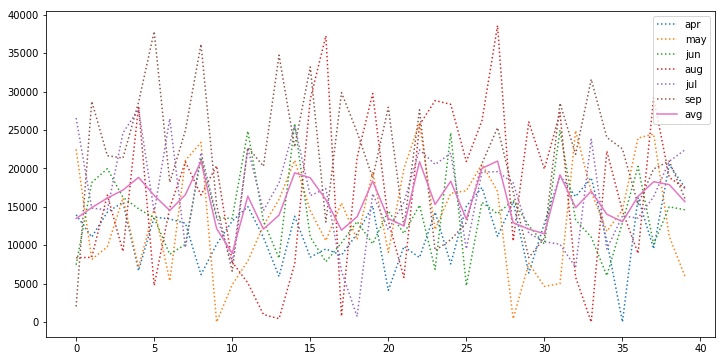

In [26]:
clusters = range(0,40)
plt.figure(figsize=(12,6))
sum_d = np.transpose([0]*40)
for g in graphs14.keys():
    out_d = dict(graphs14[g].out_degree(weight='weight')).values()
    plt.plot(clusters, out_d, ':', label=g)
    sum_d = [sum(x) for x in zip(sum_d, out_d)]
avg_d = [x/len(graphs14.keys()) for x in sum_d]
plt.plot(clusters, avg_d, label='avg')
plt.legend()
plt.show()

yah idk what this means ^^^

In [38]:
times = dict(data14['apr']['Date/Time']).values()

In [43]:
type(list(times)[0])

str